In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats

import matplotlib.pyplot as plt
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as fm

from helper import *

# Goal-directed behaviors

## 1. Manual Analysis

We measured three behaviors ("Approach hands to food (n)," "Bring the food to the mouth (n)," and "Food peeling (n)") and "Food intake (g)" in the manual analysis. One can use the samples in `Examples/Palatable/Palatable_DLC_MonkeyX_Y.csv (X = A / B / C, Y = activation / control)` and `Examples/Palatable/Palatable_DLC_params.csv` to reproduce the same results as below. Here, we show the analysis for the first behavior (AH):

In [3]:
cases = [(i, j) for i in ['A', 'B', 'C'] for j in ['activation', 'control']]
filenames = ['Examples/Palatable/Palatable_DLC_Monkey{}_{}.csv'.format(i, j) for (i, j) in cases]

crit = 0.25
filter = 360
latency = 36
dur = 36

log = pd.read_csv('Examples/Palatable/Palatable_Log_Example1.csv', index_col=0)

num_in = []
num_out = []
lowspeed_len = []
bhvs_len = []

bhv = 'Approach hands to food (from tray)'

for (case, filepath) in zip(cases, filenames):
    df = pd.read_csv(filepath, index_col=0, header=[1, 2], skiprows=0)
    manual = (log.loc[(log[['Cycle', 'Subject', 'activation / control', 'Behavior']] == ('3cycle', *case, bhv)).all(axis=1), 'Time_Relative_sf'].values * 24.0).astype(int)

    in_count, out_count = get_foc_behaviors_count(df, manual, crit, filter, latency, dur)
    num_in.append(in_count)

num_in = np.array(num_in)

pd.DataFrame(index=pd.MultiIndex.from_tuples(cases), columns=['AH'], data=num_in.reshape(-1, 1))

AH
A activation  19
  control      4
B activation  31
  control      8
C activation  38
  control      7

We compared (1) LHA<sup>GABA</sup> neuron activation and control monkeys for each index by the paired t-test and (2) divided the values of LHA<sup>GABA</sup> neuron activation monkeys by the corresponding values of control monkeys, and compared the rates of changes with 0, so that we can observe the rate of change caused by LHA<sup>GABA</sup> neuron activation.

In [4]:
data = num_in.reshape(-1, 2)

print('p-value (abs. value) : {:.3f}'.format(scipy.stats.ttest_rel(data[:, 0], data[:, 1]).pvalue))
print('p-value (rate of change) : {:.3f}'.format(scipy.stats.ttest_1samp(data[:, 0] / data[:, 1] - 1 , popmean=0).pvalue))

p-value (abs. value) : 0.038
p-value (rate of change) : 0.015


Now the example figure for the first index looks like:

c:\Users\bih\Desktop\bihfiles\Old\FNMR\chemo\Monkey_chemogenetics\helper.py:603: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


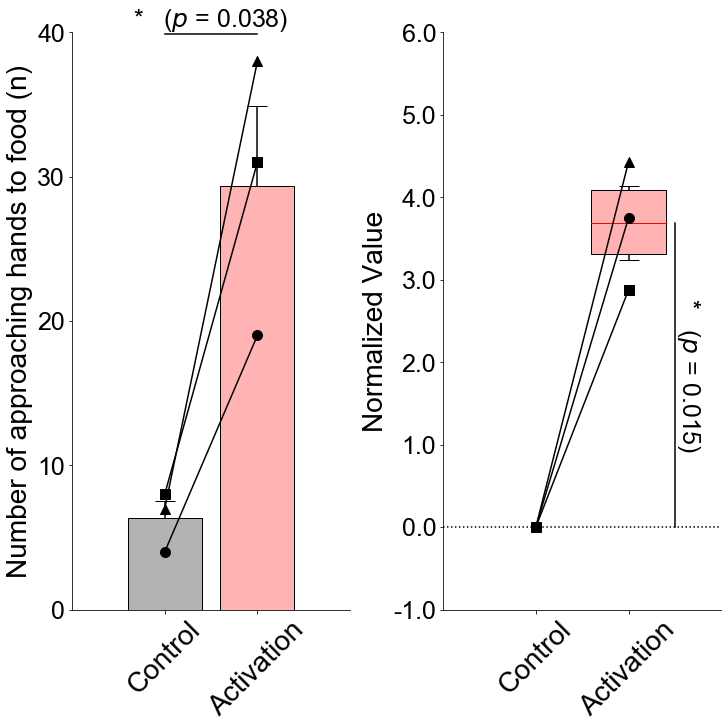

In [5]:
path = 'Figures/Fig 3C.png'
draw_picture(data.T[::-1], '', 'Number of approaching hands to food (n)', path)

Analysis on the HFHS experiment was done in a similar way, using the samples in the folder `Examples/HFHS`.

## 2. Deep Learning-based analysis

We measured three behaviors ("Tray Approach (n)," and "Bout (n)" and ""Duration in Food Zone (s)") in the deep learning-based analysis. One can use the samples in `Examples/Palatable_DLC_MonkeyX_Y.csv (X = A / B / C, Y = activation / control)` to reproduce the same results as below (those are raw outputs from DeepLabCut). We computed some parameters for each video, such as `Examples/Palatable_DLC_params.csv`.

* `fz x` is the x-coordinate of the food zone.
* `trayx` and `trayy` are the x- and y-coordinate of the tray, respectively.
* `tray-hand dist` is the threshold distance between the tray and hand, which is a criterion for "Tray Approach."
* `tray-mouth dist` is the threshold distance between the tray and mouth, which is a criterion for "Bout."

In [6]:
params_df = pd.read_csv('Examples/Palatable/Palatable_DLC_params.csv', index_col=[0, 1], header=0)
params_df

fz x  trayx  trayy  tray-hand dist  tray-mouth dist
A activation   847   1137    459       97.693398        22.203603
  control      843   1142    455      106.404887        20.248457
B activation   809   1133    450      120.904921        21.189620
  control      866   1147    454       94.540996        21.587033
C activation   906   1168    457       94.366308        22.472205
  control      845   1139    455       89.157165        17.492856

Based on those parameters, we computed each index for each video. Refer to `helper.py` for the detailed description of each function.

In [7]:
cases = [(i, j) for i in ['A', 'B', 'C'] for j in ['activation', 'control']]
filenames = ['Examples/Palatable/Palatable_DLC_Monkey{}_{}.csv'.format(i, j) for (i, j) in cases]

values = np.array([])

for case, filepath in zip(cases, filenames):
    # Approach
    params = tuple(params_df.loc[case, ['trayx', 'trayy', 'tray-hand dist']])
    coords, _, _ = return_approach(filepath, params, ll_crit=0.9, absolute=True, interval=0.2, FPS=24.0)
    appr = coords['Approach'].sum()

    # Bout
    params = tuple(params_df.loc[case, ['trayx', 'trayy', 'tray-mouth dist', 'tray-hand dist']])
    coords, _, _ = return_bout1(filepath, params, latency1=3.0, latency2=1.0, ll_crit=0.9, interval=0.2, FPS=24.0)
    bout = coords['Bout'].sum()

    # In Food Zone
    fz_x = params_df.loc[case, 'fz x']
    coords, _, _ = return_infz(filepath, fz_x, ll_crit=0.9, absolute=True)
    infz = coords['In'].sum() / 24


    values = np.concatenate((values, np.array([appr, bout, infz])))

values = values.reshape(3, 2, 3)

print(values)

[[[ 55.          31.         866.83333333]
  [ 50.          20.         217.58333333]]

 [[121.          74.         828.54166667]
  [ 80.          44.         204.        ]]

 [[268.         112.         520.45833333]
  [ 66.          18.         309.375     ]]]


Then we compared (1) LHA<sup>GABA</sup> neuron activation and control monkeys by paired t-test and (2) the rates of changes with 0 by one-sample t-test, as above.

In [8]:
indices = ["Tray Approach (n)", "Bout (n)", "Duration in Food Zone (s)"]

table_values = []

for i, idx in enumerate(indices):
    data = values[:, :, i]
    table_values.append([scipy.stats.ttest_rel(data[:, 0], data[:, 1]).pvalue, scipy.stats.ttest_1samp(data[:, 0] / data[:, 1] - 1, popmean=0).pvalue])

pd.DataFrame(data=table_values, index=indices, columns=['p-value (abs. value)','p-value (rate of change)'])

,p-value (abs. value),p-value (rate of change)
Tray Approach (n),0.305543,0.316977
Bout (n),0.214944,0.296296
Duration in Food Zone (s),0.073472,0.102782


Now the example figure for the first index looks like:

c:\Users\bih\Desktop\bihfiles\Old\FNMR\chemo\Monkey_chemogenetics\helper.py:603: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


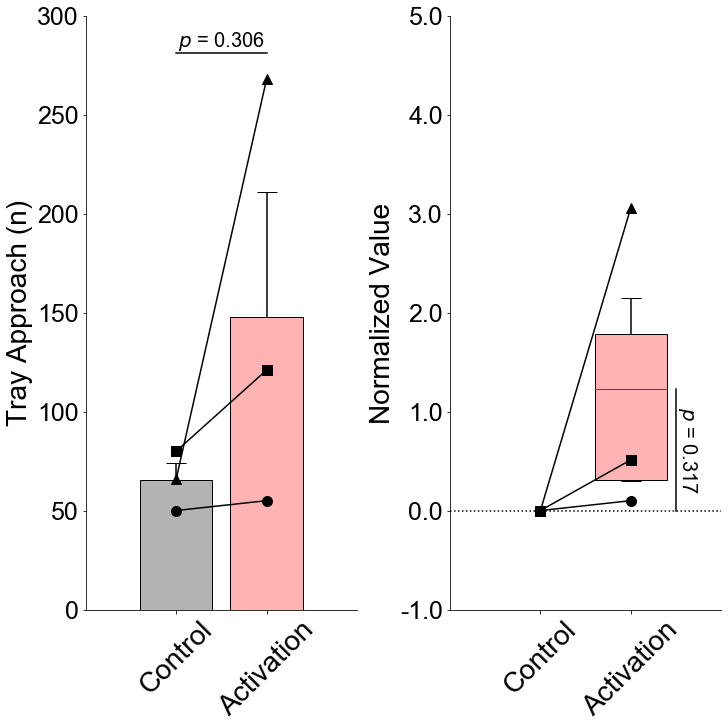

In [9]:
data = values[:, :, 0].T[::-1, :]
path = 'Figures/Fig S8A.png'
draw_picture(data, '', indices[0], path)

##  3. Total Duration of Low Locomotion

In [10]:
crit = 0.25
filter = 360
latency = 36
dur = 36

lowspeed_len = []

for (case, filepath) in zip(cases, filenames):
    df = pd.read_csv(filepath, index_col=0, header=[1, 2], skiprows=0)
    lowspeed_sessions = get_lowspeed(df, crit, filter, latency, dur)
    lowspeed_len.append((lowspeed_sessions[:, 1] - lowspeed_sessions[:, 0]).sum())

lowspeed_len = np.array(lowspeed_len)
data = lowspeed_len.reshape(-1, 2).T[::-1, :] / 24

p1 = scipy.stats.ttest_rel(data[0], data[1]).pvalue
p2 = scipy.stats.ttest_1samp(data[1] / data[0]-1, popmean=0).pvalue

pd.DataFrame(index=['Total Duration of Low Locomotion (s)'], data=[[p1, p2]], columns=['p-value (abs. value)', 'p-value (rate of change)'])


,p-value (abs. value),p-value (rate of change)
Total Duration of Low Locomotion (s),0.078078,0.023594


c:\Users\bih\Desktop\bihfiles\Old\FNMR\chemo\Monkey_chemogenetics\helper.py:603: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


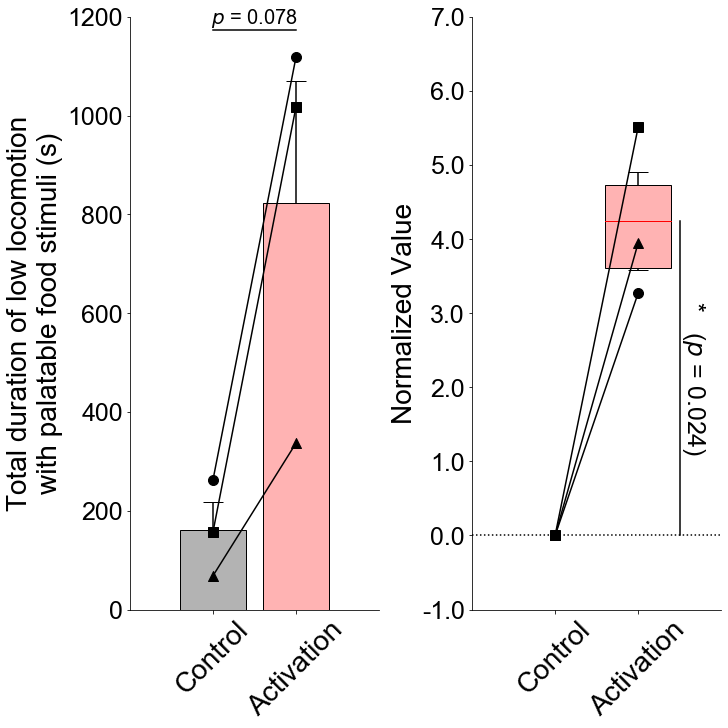

In [11]:
path = 'Figures/Fig S5A.png'
draw_picture(data, '', 'Total duration of low locomotion\nwith palatable food stimuli (s)', path)

## 4. Food Motivation on Operant Conditioning Paradigm

The following codes can be used to obtain the results related to operant experiment task.

In [20]:
files = ['Examples/Operant/Operant_control.csv', 'Examples/Operant/Operant_activation.csv']
files2 = ['Examples/Operant/Operant_anticipatory_noise_control.csv', 'Examples/Operant/Operant_anticipatory_noise_activation.csv']
colors = [(0.7, 0.7, 0.7, 1.0), (1.0, 0.7, 0.7, 1.0)]
labels = ['Control', 'Activation']

### 4.1. Cumulative Success Trials & Temporal Density

We first observed the cumulative success trials and their temporal density over time. The success trial was defined as the trial at which the monkey succeeded to obtain the food. One can use the samples in `Examples/Operant/Operant_control.csv` and `Examples/Operant/Operant_activation.csv` to reproduce the same result as below.

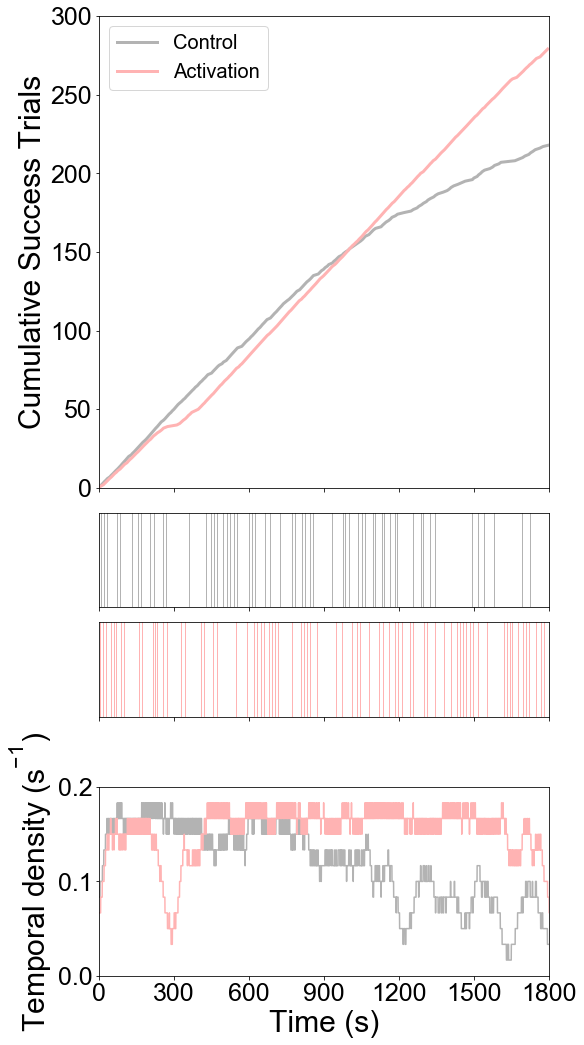

In [19]:
labelprop = arial_fontprop(30, 'bold')
tickprop = arial_fontprop(25, 'bold')
legendprop = arial_fontprop(20, 'medium')
titleprop = arial_fontprop(30, 'bold')
textprop = arial_fontprop(20, 'medium')


params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
fig, axs = plt.subplots(4, 1, figsize=(8, 14.4), constrained_layout=True, gridspec_kw={'height_ratios': [5, 1, 1, 2], 'hspace': 0}, sharex=True)

# fig, ax2 = plt.subplots(figsize=(20, 5))

times = []

for i, (f, color) in enumerate(zip(files, colors)):
    ax = axs[0]
    df = pd.read_csv(f, index_col=0, header=[0, 1])

    # df = df[df.columns[:-2]]

    cols = [(a, 'time') for a, _ in np.array(df.columns).reshape(5, 2)[:, 0]]
    cols1 = np.array(df.columns).reshape(5, 2)
    cols1[:, 1] = cols
    df.columns = pd.MultiIndex.from_tuples(cols1.reshape(-1))

    success = (df[('Trial Success', 'time')].dropna().values - df.loc[0, ('Object Presence', 'time')]) / 1000.

    time = np.arange(len(success)+1)

    ax.plot(np.concatenate(([0], success)), time, color=color, linewidth=3, label=labels[i])

    ax = axs[i+1]
    ax.bar(success, height=1, width=1, color=color)
    ax.set_yticks([])
    ax.set_ylim([0, 1])

    ax = axs[3]
    # ax = ax2
    td = temporal_density(np.isin(np.arange(18000), np.round(success * 10).astype(int)), 60.0, 10)
    ax.plot(np.arange(18000) / 10, td, color=color)


ax = axs[0]

ax.set_xlim([0, 1800])
ax.set_yticks(np.linspace(0, 300, 7, endpoint=True, dtype=int))
ax.set_yticklabels(ax.get_yticks(), fontproperties=tickprop)
ax.set_ylim([0, 300])


ax.set_ylabel('Cumulative Success Trials', fontproperties=labelprop)

ax.legend(prop=legendprop)

ax = axs[3]
ax.set_xticks(np.linspace(0, 1800, 7, endpoint=True, dtype=int))
ax.set_xticklabels(ax.get_xticks(), fontproperties=tickprop)
ax.set_xlabel('Time (s)', fontproperties=labelprop)

ax.set_yticks([0, 0.1, 0.2])
ax.set_yticklabels(ax.get_yticks(), fontproperties=tickprop)
ax.set_ylim([0, 0.2])
ax.set_ylabel('Temporal density (s' + '$^{-1}$' + ')', fontproperties=labelprop)


fig.savefig('Figures/Fig 4D,F.png')

### 4.2. Cumulative Anticipatory behaviors & Temporal Density

Next, we observed the cumulative anticipatory behaviors and their temporal density over time. The anticipatory behavior was defined as the monkey's behavior of opening the magazine door. However, the recorded numbers of 'Magazine Door Open' in `Examples/Operant/Operant_control.csv` and `Examples/Operant/Operant_activation.csv` contain noise (as the door can move freely), we manually selected noises as in `Examples/Operant/Operant_anticipatory_noise_control.csv` and `Examples/Operant/Operant_anticipatory_noise_activation.csv`.

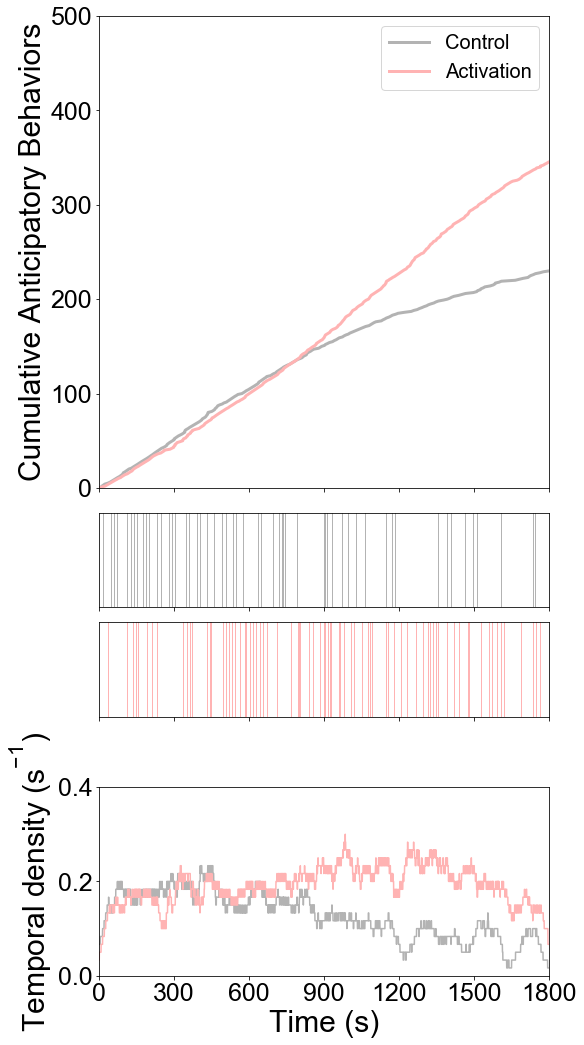

In [21]:
labelprop = arial_fontprop(30, 'bold')
tickprop = arial_fontprop(25, 'bold')
legendprop = arial_fontprop(20, 'medium')
titleprop = arial_fontprop(30, 'bold')
textprop = arial_fontprop(20, 'medium')


params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
fig, axs = plt.subplots(4, 1, figsize=(8, 14.4), constrained_layout=True, gridspec_kw={'height_ratios': [5, 1, 1, 2], 'hspace': 0}, sharex=True)

# fig, ax2 = plt.subplots(figsize=(20, 5))

times = []

for i, (f, color, f2) in enumerate(zip(files, colors, files2)):
    ax = axs[0]
    df = pd.read_csv(f, index_col=0, header=[0, 1])

    # df = df[df.columns[:-2]]

    cols = [(a, 'time') for a, _ in np.array(df.columns).reshape(5, 2)[:, 0]]
    cols1 = np.array(df.columns).reshape(5, 2)
    cols1[:, 1] = cols
    df.columns = pd.MultiIndex.from_tuples(cols1.reshape(-1))

    noise = pd.read_csv(f2, header=None)
    nans = np.where(np.isnan(noise.values[:, 0]))[0]
    true = np.concatenate(([-1], nans))+1
    noise = noise.iloc[np.isin(noise.index, true, invert=True)].dropna()
    noise[0] = noise[0].astype(int)

    mask = np.isin(df[('Magazine Door Open', 'index')].values, noise[0].values, invert=True)

    success = (df.loc[mask, ('Magazine Door Open', 'time')].values - df.loc[0, ('Object Presence', 'time')]) / 1000.

    time = np.arange(len(success)+1)

    ax.plot(np.concatenate(([0], success)), time, color=color, linewidth=3, label=labels[i])

    ax = axs[i+1]
    ax.bar(success, height=1, width=1, color=color)
    ax.set_yticks([])
    ax.set_ylim([0, 1])

    ax = axs[3]
    # ax = ax2
    td = temporal_density(np.isin(np.arange(18000), np.round(success * 10).astype(int)), 60.0, 10)
    ax.plot(np.arange(18000) / 10, td, color=color)




ax = axs[0]

ax.set_xlim([0, 1800])
ax.set_yticks(np.linspace(0, 500, 6, endpoint=True, dtype=int))
ax.set_yticklabels(ax.get_yticks(), fontproperties=tickprop)
ax.set_ylim([0, 500])


ax.set_ylabel('Cumulative Anticipatory Behaviors', fontproperties=labelprop)

ax.legend(prop=legendprop)

ax = axs[3]
ax.set_xticks(np.linspace(0, 1800, 7, endpoint=True, dtype=int))
ax.set_xticklabels(ax.get_xticks(), fontproperties=tickprop)
ax.set_xlabel('Time (s)', fontproperties=labelprop)

ax.set_yticks([0, 0.2, 0.4])
ax.set_yticklabels(ax.get_yticks(), fontproperties=tickprop)
ax.set_ylim([0, 0.4])
ax.set_ylabel('Temporal density (s' + '$^{-1}$' + ')', fontproperties=labelprop)


fig.savefig('Figures/Fig 4E,G.png')

### 4.3. Latency

Finally, we plotted the latency between (1) 'Object Presence' and 'Touch', and (2) 'Touch' and 'Door Open', respectively, over the trials.

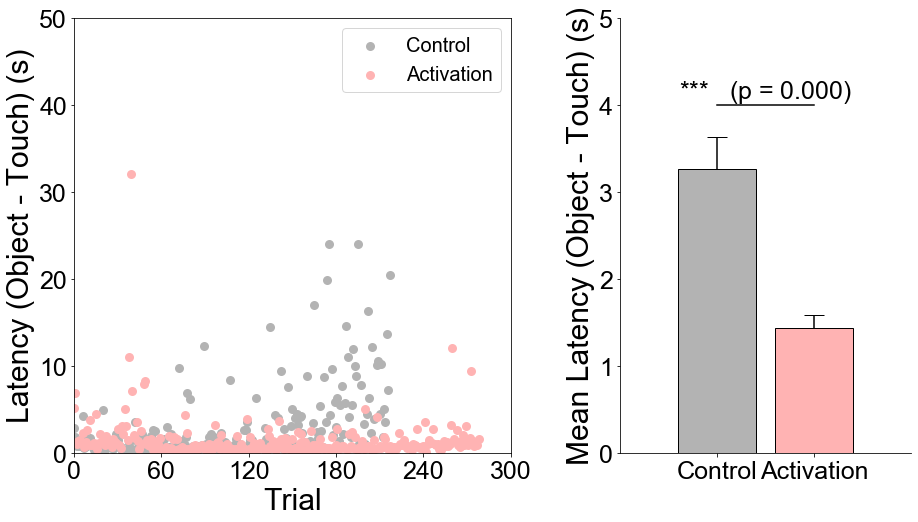

In [22]:
labelprop = arial_fontprop(30, 'bold')
tickprop = arial_fontprop(25, 'bold')
legendprop = arial_fontprop(20, 'medium')
titleprop = arial_fontprop(30, 'bold')
textprop = arial_fontprop(20, 'medium')
textprop_2 = arial_fontprop(25, 'medium')


fig, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [3, 2], 'wspace': 0.3})

means = []
latencies = []

ax = axs[0]

for i, (f, color) in enumerate(zip(files, colors)):
    df = pd.read_csv(f, index_col=0, header=[0, 1])

    cols = [(a, 'time') for a, _ in np.array(df.columns).reshape(5, 2)[:, 0]]
    cols1 = np.array(df.columns).reshape(5, 2)
    cols1[:, 1] = cols
    df.columns = pd.MultiIndex.from_tuples(cols1.reshape(-1))

    data = df[['Touch', 'Object Presence']].dropna().values[:, [1, 3]] / 1000

    latency = data[:, 0]-data[:, 1]

    ax.scatter(np.arange(len(latency)), latency, color=color, linewidth=3, label=labels[i])

    latencies.append(latency)
    means.append(latency.mean())

ax.set_xticks(np.linspace(0, 300, 6, endpoint=True, dtype=int))
ax.set_xticklabels(ax.get_xticks(), fontproperties=tickprop)
ax.set_xlim([0, 300])
ax.set_yticks(np.linspace(0, 50, 6, endpoint=True, dtype=int))
ax.set_yticklabels(ax.get_yticks(), fontproperties=tickprop)
ax.set_ylim([0, 50])

ax.set_xlabel('Trial', fontproperties=labelprop)
ax.set_ylabel('Latency (Object - Touch) (s)', fontproperties=labelprop)

ax.legend(prop=legendprop)

ax = axs[1]

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.bar([0, 1], means, color=colors, zorder=0, edgecolor='black', width=0.8)

p = scipy.stats.ttest_ind(*latencies).pvalue
txt = get_text(p)

yerr0 = np.std(latencies[0], ddof=1)/np.sqrt(len(latencies[0]))
yerr1 = np.std(latencies[1], ddof=1)/np.sqrt(len(latencies[1]))
yerr = [yerr0, yerr1]

ax.errorbar(0, means[0], yerr = yerr[0], color='black', capsize=10, zorder=-1)
ax.errorbar(1, means[1], yerr = yerr[1], color='black', capsize=10, zorder=-1)

ax.plot([0, 1], [4, 4], color='black')
ax.text(0.5, 4, txt, fontproperties=textprop_2, ha='center', va='bottom')

ax.set_xlim([-1, 2])
ax.set_xticks([0.0, 1.0])
ax.set_xticklabels(['Control', 'Activation'], fontproperties=tickprop)

ax.set_yticks(np.linspace(0, 5, 6, endpoint=True, dtype=int))
ax.set_yticklabels(ax.get_yticks(), fontproperties=tickprop)
ax.set_ylim([0, 5])
ax.set_ylabel('Mean Latency (Object - Touch) (s)', fontproperties=labelprop)

fig.savefig('Figures/Fig 4B.png')


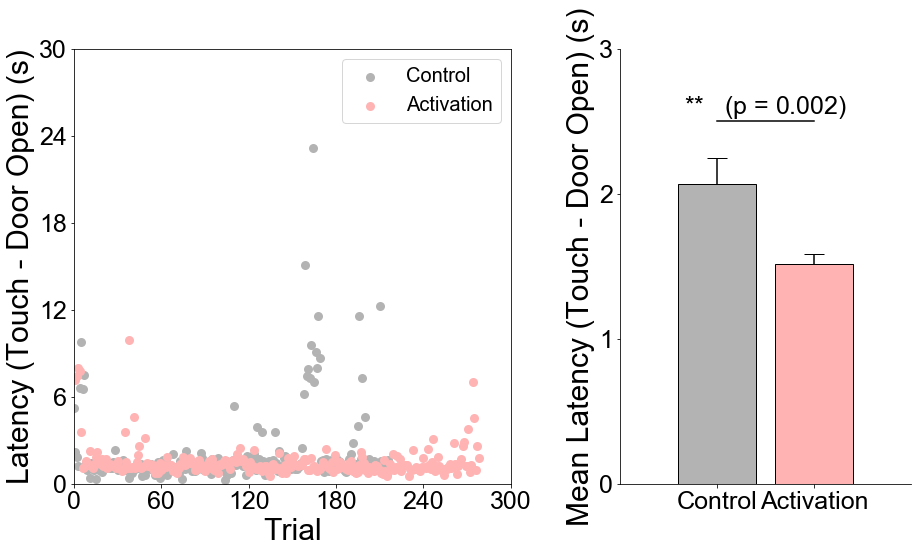

In [23]:
labelprop = arial_fontprop(30, 'bold')
tickprop = arial_fontprop(25, 'bold')
legendprop = arial_fontprop(20, 'medium')
titleprop = arial_fontprop(30, 'bold')
textprop = arial_fontprop(20, 'medium')
textprop_2 = arial_fontprop(25, 'medium')

def foo(arr1, arr2):
    j = 0
    result = []
    for val1 in arr1:
        while j in range(len(arr2)):
            if arr2[j] > val1:
                result.append(arr2[j])
                j += 1
                break
            j += 1
            continue
    return result

fig, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [3, 2], 'wspace': 0.3})

means = []
latencies = []

ax = axs[0]

for i, (f, color) in enumerate(zip(files, colors)):
    df = pd.read_csv(f, index_col=0, header=[0, 1])

    cols = [(a, 'time') for a, _ in np.array(df.columns).reshape(5, 2)[:, 0]]
    cols1 = np.array(df.columns).reshape(5, 2)
    cols1[:, 1] = cols
    df.columns = pd.MultiIndex.from_tuples(cols1.reshape(-1))

    arr1 = df[('Touch', 'time')].dropna() / 1000
    arr2 = df[('Magazine Door Open', 'time')].dropna() / 1000

    result = np.array(foo(arr1, arr2))

    latency = result - arr1[:len(result)]

    latencies.append(latency)

    ax.scatter(np.arange(len(latency)), latency, color=color, linewidth=3, label=labels[i])

    means.append(latency.mean())

ax.set_xticks(np.linspace(0, 300, 6, endpoint=True, dtype=int))
ax.set_xticklabels(ax.get_xticks(), fontproperties=tickprop)
ax.set_xlim([0, 300])
ax.set_yticks(np.linspace(0, 30, 6, endpoint=True, dtype=int))
ax.set_yticklabels(ax.get_yticks(), fontproperties=tickprop)
ax.set_ylim([0, 30])

ax.set_xlabel('Trial', fontproperties=labelprop)
ax.set_ylabel('Latency (Touch - Door Open) (s)', fontproperties=labelprop)

ax.legend(prop=legendprop)

ax = axs[1]

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.bar([0, 1], means, color=colors, zorder=0, edgecolor='black', width=0.8)

p = scipy.stats.ttest_ind(*latencies).pvalue
txt = get_text(p)

yerr0 = np.std(latencies[0], ddof=1)/np.sqrt(len(latencies[0]))
yerr1 = np.std(latencies[1], ddof=1)/np.sqrt(len(latencies[1]))
yerr = [yerr0, yerr1]

ax.errorbar(0, means[0], yerr = yerr[0], color='black', capsize=10, zorder=-1)
ax.errorbar(1, means[1], yerr = yerr[1], color='black', capsize=10, zorder=-1)

ax.plot([0, 1], [2.5, 2.5], color='black')
ax.text(0.5, 2.5, txt, fontproperties=textprop_2, ha='center', va='bottom')


ax.set_xlim([-1, 2])
ax.set_xticks([0.0, 1.0])
ax.set_xticklabels(['Control', 'Activation'], fontproperties=tickprop)

ax.set_yticks(np.linspace(0, 3, 4, endpoint=True, dtype=int))
ax.set_yticklabels(ax.get_yticks(), fontproperties=tickprop)
ax.set_ylim([0, 3])
ax.set_ylabel('Mean Latency (Touch - Door Open) (s)', fontproperties=labelprop)

fig.savefig('Figures/Fig 4C.png')